In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pathlib
import numpy as np

ModuleNotFoundError: No module named 'seaborn'

In [2]:
# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the MCDO wrapper for uncertainty estimation
class SimpleCNNWithMCDO(nn.Module):
    def __init__(self, base_model, drop_out=0.5):
        super(SimpleCNNWithMCDO, self).__init__()
        self.base_model = base_model
        self.dropout = nn.Dropout(p=drop_out)

    def forward(self, x):
        x = self.base_model.pool1(self.base_model.relu1(self.base_model.conv1(x)))
        x = self.dropout(x)
        x = self.base_model.pool2(self.base_model.relu2(self.base_model.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(self.base_model.relu3(self.base_model.fc1(x)))
        x = self.base_model.fc2(x)
        return x


In [4]:

# Data preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model = SimpleCNN().to(device)
model = SimpleCNNWithMCDO(base_model, drop_out=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(base_model.parameters(), lr=0.001)

100%|██████████| 182040794/182040794 [00:15<00:00, 11617062.15it/s]


100%|██████████| 64275384/64275384 [00:10<00:00, 5915504.66it/s] 


In [5]:

# Training
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 99:  # Print every 100 mini-batches
            print(f"Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100:.3f}")
            running_loss = 0.0

print("Finished Training")

Epoch 1, Batch 100, Loss: 2.245
Epoch 1, Batch 200, Loss: 2.155
Epoch 1, Batch 300, Loss: 1.589
Epoch 1, Batch 400, Loss: 1.148
Epoch 1, Batch 500, Loss: 0.981
Epoch 1, Batch 600, Loss: 0.892
Epoch 1, Batch 700, Loss: 0.866
Epoch 1, Batch 800, Loss: 0.808
Epoch 1, Batch 900, Loss: 0.767
Epoch 1, Batch 1000, Loss: 0.727
Epoch 1, Batch 1100, Loss: 0.739
Epoch 2, Batch 100, Loss: 0.670
Epoch 2, Batch 200, Loss: 0.684
Epoch 2, Batch 300, Loss: 0.670
Epoch 2, Batch 400, Loss: 0.663
Epoch 2, Batch 500, Loss: 0.649
Epoch 2, Batch 600, Loss: 0.631
Epoch 2, Batch 700, Loss: 0.626
Epoch 2, Batch 800, Loss: 0.645
Epoch 2, Batch 900, Loss: 0.610
Epoch 2, Batch 1000, Loss: 0.608
Epoch 2, Batch 1100, Loss: 0.604
Epoch 3, Batch 100, Loss: 0.579
Epoch 3, Batch 200, Loss: 0.575
Epoch 3, Batch 300, Loss: 0.571
Epoch 3, Batch 400, Loss: 0.596
Epoch 3, Batch 500, Loss: 0.558
Epoch 3, Batch 600, Loss: 0.583
Epoch 3, Batch 700, Loss: 0.573
Epoch 3, Batch 800, Loss: 0.549
Epoch 3, Batch 900, Loss: 0.548
Epoc

In [6]:
# Testing with uncertainty estimation
def mc_dropout_predict(model, inputs, n_samples=10):
    model.train()  # Enable dropout during prediction
    outputs = torch.stack([model(inputs) for _ in range(n_samples)])
    mean_output = outputs.mean(dim=0)
    uncertainty = outputs.var(dim=0)
    return mean_output, uncertainty

model.eval()
correct = 0
total = 0
all_uncertainties = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        mean_output, uncertainty = mc_dropout_predict(model, inputs, n_samples=10)
        _, predicted = torch.max(mean_output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_uncertainties.append(uncertainty.cpu().numpy())

print(f"Accuracy on test set: {100 * correct / total:.2f}%")

Accuracy on test set: 88.00%


In [24]:
model.eval()
correct = 0
total = 0
all_uncertainties = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        mean_output, uncertainty = mc_dropout_predict(model, inputs, n_samples=10)
        _, predicted = torch.max(mean_output, 1)
        total += labels.size(0)
        print(predicted)
        correct += (predicted == labels).sum().item()
        all_uncertainties.append(uncertainty.cpu().numpy())
        break

tensor([5, 2, 1, 0, 6, 1, 9, 1, 1, 8, 3, 6, 5, 1, 4, 4, 1, 6, 3, 4, 2, 0, 1, 9,
        2, 5, 4, 1, 4, 2, 9, 3, 6, 6, 0, 1, 5, 1, 1, 2, 3, 1, 6, 5, 2, 6, 1, 2,
        0, 6, 9, 1, 5, 1, 9, 6, 4, 5, 1, 9, 2, 2, 2, 4])


Mean values: torch.Size([40]), low


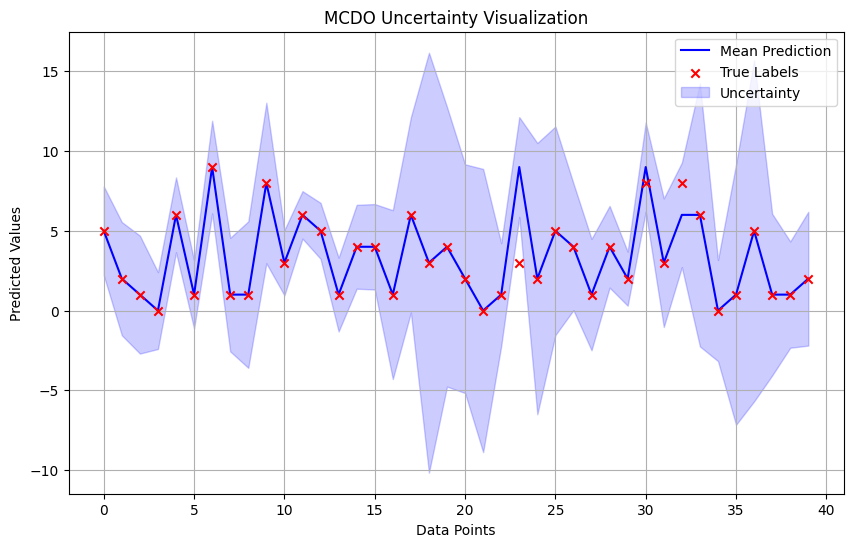

In [49]:
def make_plot_mcdo(model, inputs, labels, n_samples=50, num_data_points=40):
    model.train()
    inputs, labels = inputs.to(device), labels.to(device)
    mean_output, _ = mc_dropout_predict(model, inputs, n_samples=n_samples)

    _, means = torch.max(mean_output, 1)
    stds = np.sqrt(mean_output.var(dim=1).detach().numpy())

    mean_values = means[:num_data_points]
    upper_bound = (means + stds)[:num_data_points]
    lower_bound = (means - stds)[:num_data_points]

    print(f"Mean values: {mean_values.shape}, low")
    x = range(num_data_points)  
    plt.figure(figsize=(10, 6))
    plt.plot(x, mean_values, label="Mean Prediction", color="blue")
    plt.scatter(x, labels[:num_data_points], color="red", label="True Labels", marker="x", zorder=5)
    plt.fill_between(x, lower_bound, upper_bound, color="blue", alpha=0.2, label="Uncertainty")
    plt.title("MCDO Uncertainty Visualization")
    plt.xlabel("Data Points")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.grid(True)
    output_dir = "./results/"
    pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
    plt.savefig(f"{output_dir}/mcdo_uncertainty_plot.png")
    plt.show()


# Example call to plot uncertainties
sample_inputs, labels = next(iter(testloader))
sample_inputs = sample_inputs.to(device)
labels = labels.to(device)
make_plot_mcdo(model, sample_inputs, labels, n_samples=50, num_data_points=40)